In [1]:
#подключение необходимых библиотек
import numpy as np
from matplotlib import  pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation

In [2]:
#Возвращает значение полинома вида kind степени n в точке x
def polynomial (n, x, kind):
    #моном
    if (kind == 'monom'):
        return x**n
    #Полином Чебышева
    elif (kind == 'Chebyshev'):
        if(n == 0) :
            return 1
        elif (n == 1) :
            return x
        else:
            return 2*x*polynomial(n-1, x, kind) - polynomial(n -2, x, kind)
    #Полином Лежандра
    elif (kind == 'Legendre'):
        if (n == 0):
            return 1
        elif (n == 1):
            return x
        else:
            return (2*n -1) / n*x*polynomial(n-1, x, kind) - (n-1) / n * polynomial(n-2, x, kind)

#Функция составления матрицы A и вектора правой части b
def set_matrix (n, data, kind) :
    A = np.zeros((len(data), n+1))
    b = np.zeros(len(data))
    
    for i in range (len(data)) :
        for j in range (n+1):
            A[i][j] = polynomial(j, data[i][0], kind)
        b[i] = data [i][1]
    return A, b

#Функция аппроксимации данных с помощью QR алгоритма
def data_approximation(n, data, kind) :
    A, b = set_matrix (n, data, kind)
    #Выводим число обусловленности матрицы
    print ('cond(A): ', np.linalg.cond(A))
    #QR разложение матрицы A
    Q, R = np.linalg.qr(A)
    #Решение переопределенной СЛАУ QR методом
    coeffs = np.dot(np.linalg.inv(R), np.dot(Q.T, b))
    #Подсчет SME
    SME = np.sqrt(np.sum((np.dot(A, coeffs) - b)**2) / len(data)) / np.max(np.abs(b))
    print ('SME: ', SME)
    return np.dot(A, coeffs)

#Функция аппроксимации данных методом НУ
def data_approximation_NU(n, data, type):
    A, b = set_matrix(n, data, type)
    #Формируем матрицу AtA и вектор Atb
    AtA = np.dot(A.T, A)
    np.savetxt("Ata.txt", AtA)
    Atb = np.dot(A.T, b)
    #Выводим число обусловленности матрицы
    print ('cond(AtA): ', np.linalg.cond(AtA))
    #Решение СЛАУ
    coeffs = np.linalg.solve(AtA, Atb)
    #Подсчет SME
    SME = np.sqrt(np.sum((np.dot(A, coeffs) - b)**2) / len(data)) / np.max(np.abs(b))
    print ('SME: ', SME)
    return np.dot(A, coeffs)

from matplotlib import  pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation

#функция для построения графиков: data - исходные данные (x, y), approximation_data - данные численного алгоритма (f(x), y)
def plot_graphics(data, approximation_data, n):
    fig = plt.figure(figsize=(12,8), frameon=True)
    plt.style.use('ggplot')
    #plt.rcParams["mathtext.fontset"] = "cm"
    #plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['font.size'] = 37
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    ax = fig.add_subplot(111)    

    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')

    ax.set(facecolor='w')
    ax.grid('axis = "both"', color = 'gray')

    ax.set_xlabel('$x$', labelpad = -10)
    ax.set_ylabel('$y$', rotation = 0, labelpad = 20)

    ax.plot(data[:,0], data[:,1], color = 'blue', linestyle = '-', linewidth = 3, label='Данные')
    #ax.plot(w_obr, P_obr, color = 'red', linestyle = '-', label = 'obrabotannoe')
    ax.plot(data[:,0], approximation_data, color = 'red', linestyle = '-', linewidth = 2, label = 'Приближение при N = ' + str(n))
    ax.legend(loc=4)

    plt.show()

cond(AtA):  169390.35816780417
SME:  0.0009032395043168965


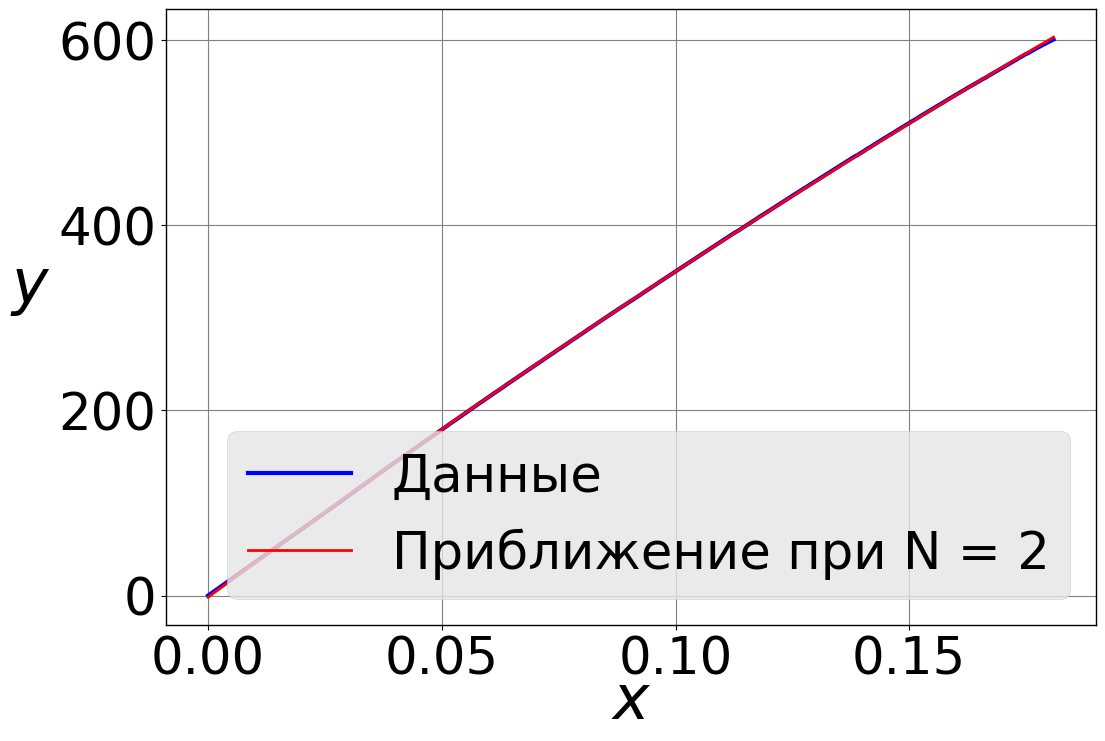

In [ ]:
#Пример вызова функции аппроксимации данных
File_name = 'data/data_1.txt'
data = np.loadtxt(File_name, dtype = float)
#Степень полинома
n = 10
#Вызов функции
c = data_approximation_NU(n, data, 'monom')
#строим графики
plot_graphics(data, c, n)